In this notebook we will create an image classifier to detect playing cards.

We will tackle this problem in 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
PyTorch version 2.5.0+cu121
Torchvision version 0.20.0+cu121
Numpy version 1.26.4
Pandas version 2.2.2


###**Step 1: PyTorch Dataset (and Dataloader)**

1. **Organization:** The dataset provides a structured way to load data and labels into the model.
2. **Flexibility with Dataloaders:** Once we wrap our dataset in a Dataloader, PyTorch can automatically handle batching, shuffling, and other preprocessing operations when training.

In [ ]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
dataset = PlayingCardDataset(
    data_dir='/content/drive/MyDrive/Datasets/Cards Dataset'
)

In [ ]:
#Just checking the total length of our dataset by using len function that we had made above
len(dataset)

8154

1


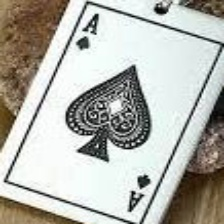

In [ ]:
#Just testing data with lable(from which class it belongs) and image printing
image, label = dataset[850]
print(label)
image

We have just created a dictionary which allows us to see that which number is belong to which label

In [ ]:
#Dictionary
data_dir = '/content/drive/MyDrive/Datasets/Cards Dataset/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

We are resizing each image to a dimension of 128x128 pixels. And converting the images from PIL format to PyTorch tensors, which are easier for PyTorch models to process.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/content/drive/MyDrive/Datasets/Cards Dataset/train'
dataset = PlayingCardDataset(data_dir, transform)

In [ ]:
#testing if our data transforms or not by taking any index
dataset[20]

(tensor([[[0.0549, 0.0627, 0.0588,  ..., 0.1098, 0.0902, 0.1020],
          [0.0784, 0.0510, 0.0431,  ..., 0.0784, 0.0980, 0.0824],
          [0.0706, 0.0667, 0.0667,  ..., 0.0745, 0.0941, 0.0980],
          ...,
          [0.0902, 0.0627, 0.0549,  ..., 0.1333, 0.0745, 0.0706],
          [0.0902, 0.0784, 0.0863,  ..., 0.1490, 0.1059, 0.0824],
          [0.1020, 0.0784, 0.0863,  ..., 0.1373, 0.1255, 0.1098]],
 
         [[0.3569, 0.3686, 0.3529,  ..., 0.4196, 0.3922, 0.4000],
          [0.3490, 0.3294, 0.3255,  ..., 0.3882, 0.4039, 0.3882],
          [0.3255, 0.3333, 0.3490,  ..., 0.3843, 0.4039, 0.4078],
          ...,
          [0.3686, 0.3451, 0.3412,  ..., 0.4157, 0.3647, 0.3608],
          [0.3647, 0.3569, 0.3765,  ..., 0.4510, 0.3882, 0.3373],
          [0.3765, 0.3569, 0.3686,  ..., 0.4235, 0.3922, 0.3529]],
 
         [[0.1137, 0.1216, 0.1059,  ..., 0.1804, 0.1490, 0.1569],
          [0.1137, 0.0941, 0.0863,  ..., 0.1451, 0.1608, 0.1451],
          [0.1059, 0.1059, 0.1137,  ...,

As you can see the below shape of our datain that 128x128 is our image size and '3' indicates that our image conaints **'rgb'** channel

In [ ]:
#checking shape of image after transform
image, label = dataset[1300]
print(label)
image.shape

8


torch.Size([3, 128, 128])

###**Dataloaders:**
When training a model, processing data in batches is faster and more efficient than handling one data sample at a time. Instead of training on a single sample, a dataloader divides the dataset into smaller groups (batches), allowing the model to learn more efficiently during each iteration.



In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
    break

Now you noticed, another thing has been added in our image shape which is defining our batch size with the number of '32'in our dataset

In [ ]:
images.shape

torch.Size([32, 3, 128, 128])

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

As above you noticed we have shuffled our dataset, so we are getting shuffled labels here below:

In [ ]:
labels

tensor([43,  2, 25, 50, 52, 21, 39, 26, 30, 40, 46,  8, 30, 14, 40, 19,  6, 24,
        26, 41, 36, 48, 28, 12, 27,  1,  4, 33, 26,  3, 43, 43])

###**Step 2: PyTorch Model**
Just as PyTorch datasets structure data loading, PyTorch models have a structured way to define and organize model architecture.

 **Creating Models**
- We can build a model from scratch by defining each layer.
- Alternatively, for tasks like image classification, we can utilize pre-built state-of-the-art architectures from libraries like timm (PyTorch Image Models) and modify them for our needs.

- **Data Shape:** Understanding the shape of the data as it flows through each layer is crucial.
- **Customizing the Final Layer:** The most common modification is adjusting the last layer to fit our specific task. For example, if we have 53 targets, we modify the final layer to output 53 values.

**Model Code Explanation:**

The SimpleCardClassifier class defines a PyTorch model for classifying playing cards. Here’s a breakdown:

__init__ method: Sets up the model.

- self.base_model: loads a pre-trained EfficientNet-B0 model using the timm library and removes the final layer to extract features.
- self.features: extracts all but the last layer of the base model for feature extraction.
- self.classifier: is a custom head for classification. It flattens the extracted features and uses a linear layer to map them to 53 output classes (one for each target).

**forward method:**

Passes input x through the features to extract features.
Feeds these features into the classifier to generate the final output predictions.


In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [ ]:
model = SimpleCardClassifer(num_classes=53)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
#We can se our model(efficientnet_b0) architecture details
print(model)

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (c

We are just testing our model by passing the data into the model that what actual size we are getting of our data which we want as 32 as a **'batch size'** and 53 as **'no of classes'**

In [ ]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

### **Step 3: The Training Loop**
With an understanding of PyTorch datasets and models, we now focus on training the model.

To evaluate performance, we often split data into train and validation sets. This helps test the model on unseen data.
- **Epoch**: A single pass through the entire training dataset.
- **Step**: A single batch of data passed through the model, as defined by the Dataloader.

**Training Loop Overview:**
Load data in batches.
- Compute loss (the difference between predictions and true labels).
- Perform backpropagation to update model weights.

Although there are pre-built packages to automate training loops, understanding the basics is essential for customizing and troubleshooting models.

- **Optimizer:** Adam is a great default choice for most tasks.
- **Loss Function:** Defines what the model aims to minimize (optimize).

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

We are just testing our loss before even training our model here. That's why it showing the high value of loss

In [ ]:
criterion(example_out, labels)
#print(example_out.shape, labels.shape)

tensor(4.1072, grad_fn=<NllLossBackward0>)

**Seting Up Datasets**

Now we are setting up data transformations, datasets, and dataloaders for training, validation, and testing. It resizes images to 128x128 pixels and converts them to tensors. Three datasets **(train_dataset, val_dataset, and test_dataset)** are created to load data from specified folders. The dataloaders **(train_loader, val_loader, and test_loader)** manage batching **(32 samples)** and shuffling for efficient model training, with train_loader shuffling data while val_loader and test_loader do not.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '../content/drive/MyDrive/Datasets/Cards Dataset/train/'
valid_folder = '../content/drive/MyDrive/Datasets/Cards Dataset/valid/'
test_folder = '../content/drive/MyDrive/Datasets/Cards Dataset/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

**Loop For Training The Model**

In [ ]:
# Simple training loop
num_epochs = 1
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 1.5192840544649586, Validation loss: 0.45908854772459784


  **Note:**
  As you may have noticed, I only ran one epoch of training. The reason for this is that I didn't have access to a GPU, and for PyTorch neural network models, running on a GPU significantly speeds up the training process. Training without a GPU can be extremely slow; in my case, it took around 2 hours to complete just one epoch. If you have access to a GPU, you can achieve better results by increasing the number of epochs, as this will reduce the training loss more effectively and efficiently.

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

###**Step 4: Evaluating Model Results**

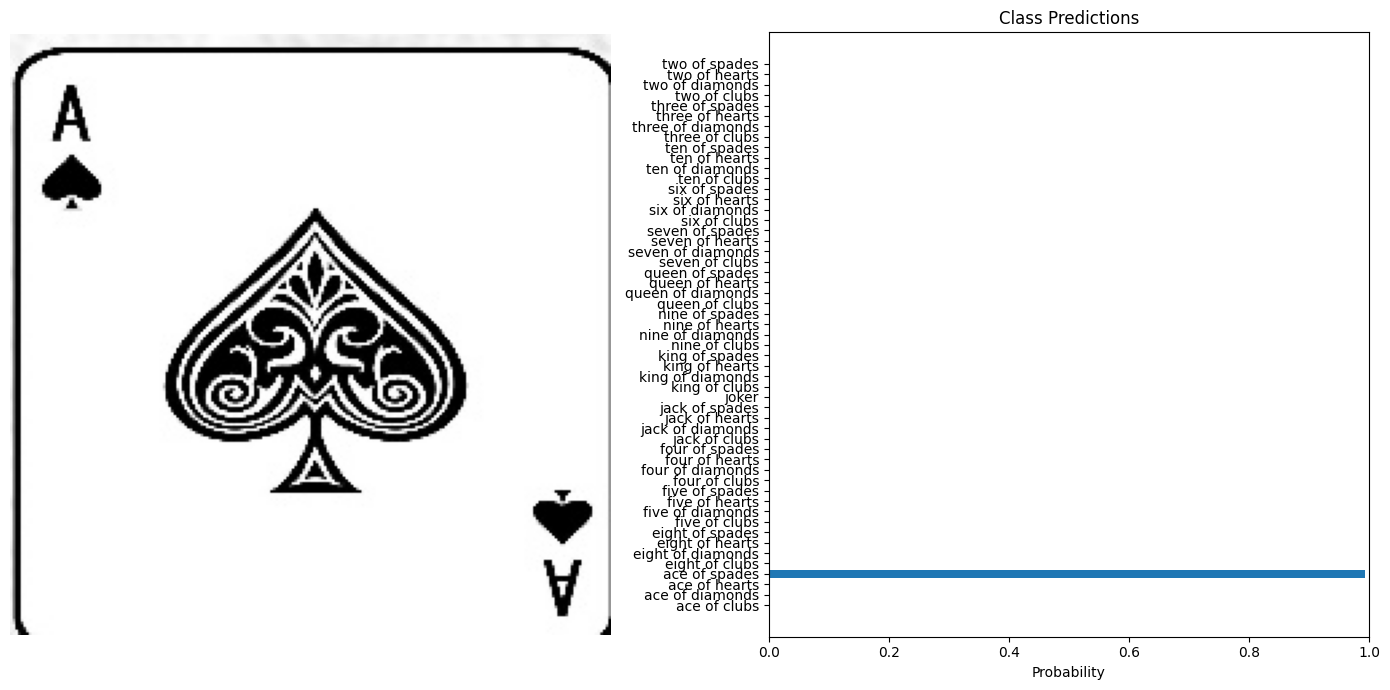

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/content/drive/MyDrive/Datasets/Cards Dataset/test/ace of spades/3.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

In [ ]:
from glob import glob
test_images = glob('../content/drive/MyDrive/Datasets/Cards Dataset/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)